In [1]:
import requests
import pandas as pd
from datetime import datetime, timedelta, timezone
from IPython.display import display

BASE_URL = "https://history.deribit.com/api/v2"
CURRENCY = "BTC"
KIND = "option"
LOOKBACK_DAYS = 90
WINDOW_DAYS = 3
RESOLUTION = "1"
CSV_PATH = "btc_options_90d_3d_window.csv"
UNDERLYING_INSTRUMENT = "BTC-PERPETUAL"
RISK_FREE_RATE = 0.03

def get_instruments():
    r = requests.get(
        f"{BASE_URL}/public/get_instruments",
        params={"currency": CURRENCY, "kind": KIND, "expired": "true"},
        timeout=30,
    )
    r.raise_for_status()
    data = r.json().get("result", [])
    if not data:
        return pd.DataFrame()
    df = pd.DataFrame(data)
    if "expiration_timestamp" in df.columns:
        df["expiration_timestamp"] = pd.to_datetime(df["expiration_timestamp"], unit="ms", utc=True)
    if "creation_timestamp" in df.columns:
        df["creation_timestamp"] = pd.to_datetime(df["creation_timestamp"], unit="ms", utc=True)
    if "strike" in df.columns:
        df["strike"] = pd.to_numeric(df["strike"], errors="coerce")
    now_utc = datetime.now(timezone.utc)
    start_utc = now_utc - timedelta(days=LOOKBACK_DAYS)
    df = df[(df["expiration_timestamp"] >= start_utc) & (df["expiration_timestamp"] <= now_utc)]
    df = df.sort_values("expiration_timestamp")
    return df

def fetch_tv_data(instrument_name, start_ms, end_ms):
    r = requests.get(
        f"{BASE_URL}/public/get_tradingview_chart_data",
        params={
            "instrument_name": instrument_name,
            "start_timestamp": start_ms,
            "end_timestamp": end_ms,
            "resolution": RESOLUTION,
        },
        timeout=60,
    )
    r.raise_for_status()
    res = r.json().get("result", {})
    if res.get("status") != "ok":
        return pd.DataFrame()
    ticks = res.get("ticks", [])
    if not ticks:
        return pd.DataFrame()
    df = pd.DataFrame(
        {
            "time": pd.to_datetime(ticks, unit="ms", utc=True),
            "open": res.get("open", []),
            "high": res.get("high", []),
            "low": res.get("low", []),
            "close": res.get("close", []),
            "volume": res.get("volume", []),
            "cost": res.get("cost", []),
        }
    )
    num_cols = ["open", "high", "low", "close", "volume", "cost"]
    df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce")
    return df

df_inst = get_instruments()

if df_inst.empty:
    print("Нет истёкших BTC-опционов за последние 90 дней")
else:
    global_start_dt = df_inst["expiration_timestamp"].min() - timedelta(days=WINDOW_DAYS)
    global_end_dt = df_inst["expiration_timestamp"].max()
    global_start_ms = int(global_start_dt.timestamp() * 1000)
    global_end_ms = int(global_end_dt.timestamp() * 1000)

    try:
        df_underlying = fetch_tv_data(UNDERLYING_INSTRUMENT, global_start_ms, global_end_ms)
    except Exception as e:
        print("Ошибка загрузки базового актива", e)
        df_underlying = pd.DataFrame()

    if not df_underlying.empty:
        df_underlying = df_underlying[["time", "close"]].rename(columns={"close": "underlying_price"})

    all_rows = []
    for _, row in df_inst.iterrows():
        expiry = row["expiration_timestamp"]
        start_dt = expiry - timedelta(days=WINDOW_DAYS)
        start_ms = int(start_dt.timestamp() * 1000)
        end_ms = int(expiry.timestamp() * 1000)
        try:
            df_hist = fetch_tv_data(row["instrument_name"], start_ms, end_ms)
        except Exception as e:
            print("Ошибка загрузки для", row["instrument_name"], e)
            continue
        if df_hist.empty:
            continue
        df_hist["instrument_name"] = row["instrument_name"]
        df_hist["expiration_timestamp"] = row["expiration_timestamp"]
        df_hist["option_type"] = row.get("option_type", None)
        df_hist["strike"] = row["strike"]
        df_hist["mid_price"] = df_hist["close"]
        df_hist["has_trade"] = df_hist["volume"] > 0
        df_hist["time_iso"] = df_hist["time"].dt.strftime("%Y-%m-%dT%H:%M:%SZ")
        all_rows.append(df_hist)

    if not all_rows:
        print("Не удалось получить историю свечей ни по одному опциону")
    else:
        df_all = pd.concat(all_rows, ignore_index=True)
        df_all = df_all.sort_values(["instrument_name", "time"])

        if not df_underlying.empty:
            df_all = pd.merge_asof(
                df_all.sort_values("time"),
                df_underlying.sort_values("time"),
                on="time",
                direction="nearest"
            )
        else:
            df_all["underlying_price"] = pd.NA

        seconds_to_expiry = (df_all["expiration_timestamp"] - df_all["time"]).dt.total_seconds()
        df_all["tau_years"] = seconds_to_expiry / (365 * 24 * 3600)
        df_all["risk_free_rate"] = RISK_FREE_RATE
        df_all["sigma_hv"] = pd.NA
        df_all["sigma_iv"] = pd.NA

        for col in ["delta", "gamma", "vega", "theta", "rho"]:
            df_all[col] = pd.NA

        cols = [
            "instrument_name",
            "expiration_timestamp",
            "option_type",
            "strike",
            "time",
            "time_iso",
            "mid_price",
            "underlying_price",
            "tau_years",
            "risk_free_rate",
            "sigma_hv",
            "sigma_iv",
            "delta",
            "gamma",
            "vega",
            "theta",
            "rho",
            "has_trade",
            "volume",
            "cost",
        ]
        df_all = df_all[cols]
        df_all.to_csv(CSV_PATH, index=False)
        display(df_inst[["instrument_name", "option_type", "strike", "expiration_timestamp"]].head())
        display(df_all.head())
        print("Сохранено строк:", len(df_all), "в файл:", CSV_PATH)


,instrument_name,option_type,strike,expiration_timestamp
103122,BTC-28AUG25-104000-C,call,104000.0,2025-08-28 08:00:00+00:00
103142,BTC-28AUG25-115000-C,call,115000.0,2025-08-28 08:00:00+00:00
103143,BTC-28AUG25-115000-P,put,115000.0,2025-08-28 08:00:00+00:00
103144,BTC-28AUG25-116000-C,call,116000.0,2025-08-28 08:00:00+00:00
103145,BTC-28AUG25-116000-P,put,116000.0,2025-08-28 08:00:00+00:00


,instrument_name,expiration_timestamp,option_type,strike,time,time_iso,mid_price,underlying_price,tau_years,risk_free_rate,sigma_hv,sigma_iv,delta,gamma,vega,theta,rho,has_trade,volume,cost
0,BTC-28AUG25-117000-C,2025-08-28 08:00:00+00:00,call,117000.0,2025-08-25 08:00:00+00:00,2025-08-25T08:00:00Z,0.0019,84032.0,0.008219,0.03,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,False,0.0,0.0
1,BTC-28AUG25-107000-P,2025-08-28 08:00:00+00:00,put,107000.0,2025-08-25 08:00:00+00:00,2025-08-25T08:00:00Z,0.0026,84032.0,0.008219,0.03,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,False,0.0,0.0
2,BTC-28AUG25-111000-C,2025-08-28 08:00:00+00:00,call,111000.0,2025-08-25 08:00:00+00:00,2025-08-25T08:00:00Z,0.0175,84032.0,0.008219,0.03,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,False,0.0,0.0
3,BTC-28AUG25-106000-P,2025-08-28 08:00:00+00:00,put,106000.0,2025-08-25 08:00:00+00:00,2025-08-25T08:00:00Z,0.0022,84032.0,0.008219,0.03,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,False,0.0,0.0
4,BTC-28AUG25-118000-C,2025-08-28 08:00:00+00:00,call,118000.0,2025-08-25 08:00:00+00:00,2025-08-25T08:00:00Z,0.0012,84032.0,0.008219,0.03,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,False,0.0,0.0


Сохранено строк: 13264059 в файл: btc_options_90d_3d_window.csv


In [9]:
import pandas as pd
from IPython.display import display

CSV_IN = "btc_options_90d_3d_window.csv"
CSV_OUT = "btc_options_90d_3d_window_filtered.csv"
MIN_COVERAGE = 0.95
MIN_TRADE_SHARE = 0.01

df = pd.read_csv(CSV_IN)

df["time"] = pd.to_datetime(df["time"], utc=True)
df["expiration_timestamp"] = pd.to_datetime(df["expiration_timestamp"], utc=True)
df["has_trade"] = df["has_trade"].astype(str).str.lower().isin(["true", "1"])

group = df.groupby("instrument_name").agg(
    expiration=("expiration_timestamp", "first"),
    first_time=("time", "min"),
    last_time=("time", "max"),
    rows=("time", "size"),
    traded_minutes=("has_trade", "sum"),
).reset_index()

group["window_start"] = group["expiration"] - pd.Timedelta(days=3)
group["expected_minutes"] = (
    (group["expiration"] - group["window_start"]).dt.total_seconds() / 60
).astype(int) + 1
group["coverage_pct"] = group["rows"] / group["expected_minutes"]
group["trade_share"] = group["traded_minutes"] / group["rows"]

mask = (group["coverage_pct"] >= MIN_COVERAGE) & (group["trade_share"] >= MIN_TRADE_SHARE)
group_kept = group[mask].copy()

df_filtered = df[df["instrument_name"].isin(group_kept["instrument_name"])].copy()
df_filtered = df_filtered.sort_values(["instrument_name", "time"])

cols_to_drop = [c for c in ["open", "high", "low", "close"] if c in df_filtered.columns]
if cols_to_drop:
    df_filtered = df_filtered.drop(columns=cols_to_drop)

df_filtered.to_csv(CSV_OUT, index=False)

print("Всего опционов:", group.shape[0])
print("Осталось после фильтра:", group_kept.shape[0])
print("Всего строк исходный файл:", df.shape[0])
print("Всего строк после фильтра:", df_filtered.shape[0])
print("Файл сохранён:", CSV_OUT)

display(group_kept[["instrument_name", "expiration", "rows", "expected_minutes", "coverage_pct", "trade_share"]].head())
display(df_filtered.head())


Всего опционов: 3371
Осталось после фильтра: 1571
Всего строк исходный файл: 13264059
Всего строк после фильтра: 6786561
Файл сохранён: btc_options_90d_3d_window_filtered.csv


,instrument_name,expiration,rows,expected_minutes,coverage_pct,trade_share
1,BTC-10NOV25-100000-P,2025-11-10 08:00:00+00:00,4321,4321,1.0,0.031011
3,BTC-10NOV25-101000-P,2025-11-10 08:00:00+00:00,4321,4321,1.0,0.028234
4,BTC-10NOV25-102000-C,2025-11-10 08:00:00+00:00,4321,4321,1.0,0.026614
5,BTC-10NOV25-102000-P,2025-11-10 08:00:00+00:00,4321,4321,1.0,0.041194
6,BTC-10NOV25-103000-C,2025-11-10 08:00:00+00:00,4321,4321,1.0,0.039343


,instrument_name,expiration_timestamp,option_type,strike,time,time_iso,mid_price,underlying_price,tau_years,risk_free_rate,sigma_hv,sigma_iv,delta,gamma,vega,theta,rho,has_trade,volume,cost
10710229,BTC-10NOV25-100000-P,2025-11-10 08:00:00+00:00,put,100000.0,2025-11-07 08:00:00+00:00,2025-11-07T08:00:00Z,0.007,84032.0,0.008219,0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.0,0.0
10710272,BTC-10NOV25-100000-P,2025-11-10 08:00:00+00:00,put,100000.0,2025-11-07 08:01:00+00:00,2025-11-07T08:01:00Z,0.007,84032.0,0.008217,0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.0,0.0
10710332,BTC-10NOV25-100000-P,2025-11-10 08:00:00+00:00,put,100000.0,2025-11-07 08:02:00+00:00,2025-11-07T08:02:00Z,0.007,84032.0,0.008215,0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.0,0.0
10710454,BTC-10NOV25-100000-P,2025-11-10 08:00:00+00:00,put,100000.0,2025-11-07 08:03:00+00:00,2025-11-07T08:03:00Z,0.007,84032.0,0.008213,0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.0,0.0
10710554,BTC-10NOV25-100000-P,2025-11-10 08:00:00+00:00,put,100000.0,2025-11-07 08:04:00+00:00,2025-11-07T08:04:00Z,0.007,84032.0,0.008212,0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,0.0,0.0


## Как считаются Greeks в модели Black–Scholes

Обозначения:

- `S` — цена базового актива  
- `K` — страйк  
- `T` — время до экспирации в годах  
- `r` — безрисковая ставка  
- `σ` — волатильность (implied volatility)  

Сначала считаются вспомогательные величины:

- `d1 = ( ln(S / K) + (r + 0.5 · σ²) · T ) / ( σ · √T )`
- `d2 = d1 - σ · √T`

Также используются:

- `φ(d1)` — плотность стандартного нормального распределения  
- `N(d)` — функция распределения стандартного нормального распределения  

---

### Delta

Показывает, как изменится цена опциона при изменении цены базового актива на 1 единицу.

- Для call: `Δ_call = N(d1)`  
- Для put: `Δ_put = N(d1) - 1`

---

### Gamma

Показывает, как быстро меняется delta при изменении цены базового актива.

- `Γ = φ(d1) / ( S · σ · √T )`

---

### Vega

Чувствительность цены опциона к изменению волатильности.

- `Vega = S · φ(d1) · √T`

Обычно понимается как изменение цены опциона при изменении `σ` на 1. Для «на 1%» vega делят на 100.

---

### Theta

Показывает, как меняется цена опциона с течением времени (time decay).

- Для call:  
  `Θ_call = - ( S · φ(d1) · σ ) / ( 2 · √T ) - r · K · e^(-r · T) · N(d2)`
- Для put:  
  `Θ_put  = - ( S · φ(d1) · σ ) / ( 2 · √T ) + r · K · e^(-r · T) · N(-d2)`

Часто значение делят на 365, чтобы получить «в день».

---

### Rho

Чувствительность цены опциона к изменению процентной ставки.

- Для call: `ρ_call = K · T · e^(-r · T) · N(d2)`  
- Для put:  `ρ_put  = -K · T · e^(-r · T) · N(-d2)`


In [5]:
import numpy as np
import pandas as pd
from math import log, sqrt, exp
from scipy.stats import norm
from scipy.optimize import brentq
from joblib import Parallel, delayed
import multiprocessing

INPUT_CSV_PATH = "btc_options_90d_3d_window_filtered.csv"
OUTPUT_CSV_PATH = "btc_options_90d_3d_window_with_greeks.csv"
STEP_MINUTES = 10
N_JOBS = multiprocessing.cpu_count()

df_all = pd.read_csv(INPUT_CSV_PATH)

df_all["time"] = pd.to_datetime(df_all["time"], utc=True)

df_all.reset_index(drop=False, inplace=True)
df_all.rename(columns={"index": "orig_index"}, inplace=True)

for col in ["mid_price", "underlying_price", "strike", "tau_years", "risk_free_rate"]:
    df_all[col] = pd.to_numeric(df_all[col], errors="coerce")

if "sigma_iv" not in df_all.columns:
    df_all["sigma_iv"] = np.nan
for col in ["delta", "gamma", "vega", "theta", "rho"]:
    if col not in df_all.columns:
        df_all[col] = np.nan

df_all = df_all.sort_values(["instrument_name", "time"])
df_all["row_in_instr"] = df_all.groupby("instrument_name").cumcount()

df_all["option_price_usd"] = df_all["mid_price"] * df_all["underlying_price"]

mask = (
    (df_all["option_price_usd"] > 0)
    & (df_all["underlying_price"] > 0)
    & (df_all["strike"] > 0)
    & (df_all["tau_years"] > 0)
)

df_target = df_all.loc[mask].copy()
df_iv = df_target[df_target["row_in_instr"] % STEP_MINUTES == 0].copy()

if df_iv.empty:
    df_all.to_csv(OUTPUT_CSV_PATH, index=False)
else:
    def bs_price(S, K, T, r, sigma, opt_type):
        if T <= 0 or S <= 0 or K <= 0 or sigma <= 0:
            return np.nan
        d1 = (log(S / K) + (r + 0.5 * sigma * sigma) * T) / (sigma * sqrt(T))
        d2 = d1 - sigma * sqrt(T)
        if opt_type == "call":
            return S * norm.cdf(d1) - K * exp(-r * T) * norm.cdf(d2)
        else:
            return K * exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

    def bs_greeks(S, K, T, r, sigma, opt_type):
        if T <= 0 or S <= 0 or K <= 0 or sigma <= 0:
            return np.nan, np.nan, np.nan, np.nan, np.nan
        d1 = (log(S / K) + (r + 0.5 * sigma * sigma) * T) / (sigma * sqrt(T))
        d2 = d1 - sigma * sqrt(T)
        pdf_d1 = norm.pdf(d1)
        if opt_type == "call":
            delta = norm.cdf(d1)
            theta = -(S * pdf_d1 * sigma) / (2 * sqrt(T)) - r * K * exp(-r * T) * norm.cdf(d2)
            rho = K * T * exp(-r * T) * norm.cdf(d2)
        else:
            delta = norm.cdf(d1) - 1.0
            theta = -(S * pdf_d1 * sigma) / (2 * sqrt(T)) + r * K * exp(-r * T) * norm.cdf(-d2)
            rho = -K * T * exp(-r * T) * norm.cdf(-d2)
        gamma = pdf_d1 / (S * sigma * sqrt(T))
        vega = S * pdf_d1 * sqrt(T)
        return delta, gamma, vega, theta, rho

    def implied_vol_row(row):
        S = row["underlying_price"]
        K = row["strike"]
        T = row["tau_years"]
        r = row["risk_free_rate"]
        price = row["option_price_usd"]
        opt_type = row["option_type"]
        if not (isinstance(opt_type, str) and opt_type in ("call", "put")):
            return np.nan
        if S <= 0 or K <= 0 or T <= 0 or price <= 0:
            return np.nan
        def f(sigma):
            return bs_price(S, K, T, r, sigma, opt_type) - price
        try:
            low = 1e-6
            high = 5.0
            f_low = f(low)
            f_high = f(high)
            if not np.isfinite(f_low) or not np.isfinite(f_high):
                return np.nan
            if f_low * f_high > 0:
                return np.nan
            iv = brentq(f, low, high, maxiter=100, xtol=1e-6)
            if iv <= 0 or not np.isfinite(iv):
                return np.nan
            return iv
        except Exception:
            return np.nan

    def greeks_row(row):
        S = row["underlying_price"]
        K = row["strike"]
        T = row["tau_years"]
        r = row["risk_free_rate"]
        sigma = row["sigma_iv"]
        opt_type = row["option_type"]
        if not np.isfinite(sigma) or sigma <= 0:
            return pd.Series([np.nan, np.nan, np.nan, np.nan, np.nan])
        delta, gamma, vega, theta, rho = bs_greeks(S, K, T, r, sigma, opt_type)
        return pd.Series([delta, gamma, vega, theta, rho])

    def process_chunk(chunk):
        chunk = chunk.copy()
        chunk["sigma_iv"] = chunk.apply(implied_vol_row, axis=1)
        chunk[["delta", "gamma", "vega", "theta", "rho"]] = chunk.apply(greeks_row, axis=1)
        return chunk[["orig_index", "sigma_iv", "delta", "gamma", "vega", "theta", "rho"]]

    chunks = np.array_split(df_iv, N_JOBS)
    results = Parallel(n_jobs=N_JOBS)(delayed(process_chunk)(ch) for ch in chunks)
    res_df = pd.concat(results, ignore_index=True).set_index("orig_index")

    df_all = df_all.set_index("orig_index")
    df_all.loc[res_df.index, "sigma_iv"] = res_df["sigma_iv"]
    df_all.loc[res_df.index, ["delta", "gamma", "vega", "theta", "rho"]] = res_df[["delta", "gamma", "vega", "theta", "rho"]]

    df_all = df_all.sort_values(["instrument_name", "time"])
    df_all[["sigma_iv", "delta", "gamma", "vega", "theta", "rho"]] = (
        df_all.groupby("instrument_name")[["sigma_iv", "delta", "gamma", "vega", "theta", "rho"]].ffill()
    )

    df_all.reset_index(drop=False, inplace=True)
    df_all.to_csv(OUTPUT_CSV_PATH, index=False)

    print("Строк с ненулевой sigma_iv:", df_all["sigma_iv"].notna().sum())



/opt/anaconda3/lib/python3.13/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Строк с ненулевой sigma_iv: 3503573


Instrument: BTC-26SEP25-108000-P
Rows: 4321
Trade share: 0.07660263827817634


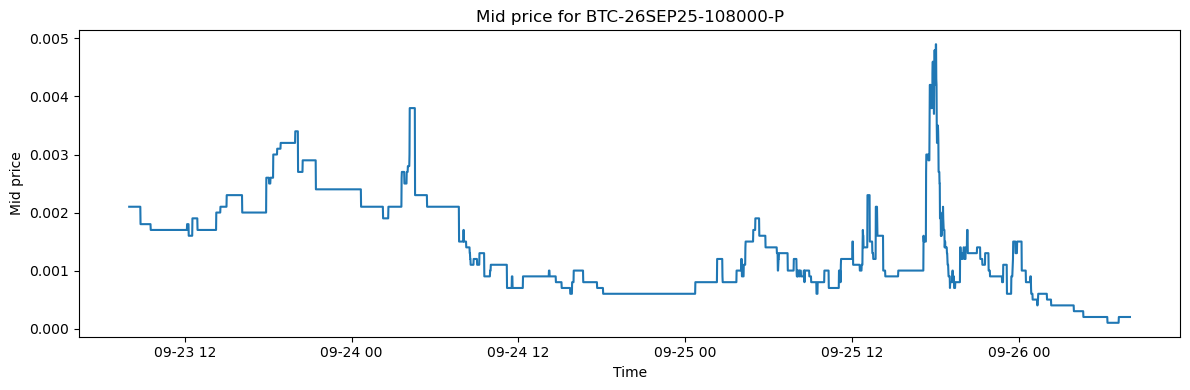

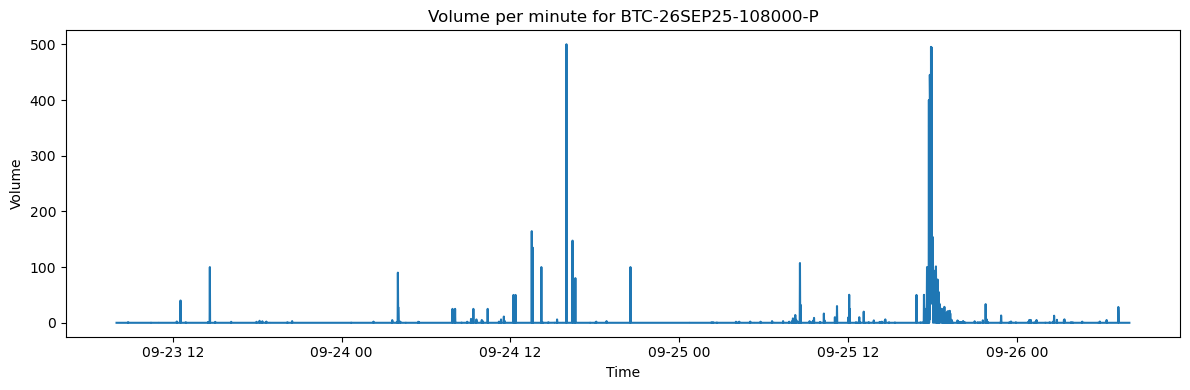

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

CSV_FILTERED = "btc_options_90d_3d_window_with_greeks.csv"

df = pd.read_csv(CSV_FILTERED)

df["time"] = pd.to_datetime(df["time"], utc=True)
df["expiration_timestamp"] = pd.to_datetime(df["expiration_timestamp"], utc=True)

grp = df.groupby("instrument_name").agg(
    rows=("time", "size"),
    volume_sum=("volume", "sum"),
    traded_minutes=("has_trade", "sum"),
).reset_index()

grp["trade_share"] = grp["traded_minutes"] / grp["rows"]

grp = grp.sort_values("volume_sum", ascending=False)
instrument = grp.iloc[0]["instrument_name"]

df_inst = df[df["instrument_name"] == instrument].copy()
df_inst = df_inst.sort_values("time")

print("Instrument:", instrument)
print("Rows:", len(df_inst))
print("Trade share:", grp.iloc[0]["trade_share"])

plt.figure(figsize=(12, 4))
plt.plot(df_inst["time"], df_inst["mid_price"])
plt.title(f"Mid price for {instrument}")
plt.xlabel("Time")
plt.ylabel("Mid price")
plt.tight_layout()

plt.figure(figsize=(12, 4))
plt.plot(df_inst["time"], df_inst["volume"])
plt.title(f"Volume per minute for {instrument}")
plt.xlabel("Time")
plt.ylabel("Volume")
plt.tight_layout()
